# Bitcoin Prediction using Deep Learning

This time, you will build a basic Neural Network model to predict Bitcoin price based on historical Data.
This notebook helps you to train a model but you can use it however you want.

In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler

import helper_functions as hf

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline

# Import Data
Our Data come from https://blockchain.info/.

Here, we load data into a Pandas DataFrame

In [2]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), delimiter=",")

In [3]:
df_blockchain.head()

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.0,12.018816,1.777774e+06,52318.011503,0.0,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,358543.612114,58615.641320,403275.612279,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.0,13.263925,1.755425e+06,48306.468911,0.0,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,302619.024544,74521.484625,461287.989830,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.0,12.914875,1.755425e+06,60431.444952,0.0,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,299226.130646,79422.402932,470180.625359,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.0,10.995096,1.755425e+06,34345.021913,0.0,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,674606.861338,82696.853247,461448.441118,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.0,10.733308,1.755425e+06,36805.913687,0.0,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,354198.945778,68238.166521,353473.702578,7.285375e+06,3.801833e+07


# Explore Dataset

We already explored dataset before, but you can draw other plots to analyse data if you want.

Idea : you can use pandas_profiling 

```python
from pandas_profiling import ProfileReport
ProfileReport(df)
```

In [4]:
# Your Code Here

In [5]:
# get columns (You can add more columns to analyse results)
columns = ["market-price"]
dataset = df_blockchain[columns]

# Data scaling

Here we scale the price between 0 and 1, this will help the optimization algorithm converge faster.

See the following figure (source : Andrew Ng https://www.andrewng.org ) :

![alt text](../data/feature-scaling.png "Title")

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))

In [7]:
print(dataset.shape)
print(type(dataset))

(3544, 1)
<class 'numpy.ndarray'>


In [8]:
dataset[6,0]

4.468771625943673e-05

In [9]:
#dataset[0:3]
dataset

array([[7.20668100e-05],
       [6.12095832e-05],
       [5.69611031e-05],
       ...,
       [5.46830366e-01],
       [6.09362486e-01],
       [6.04357304e-01]])

In [10]:
dataset[3:6,:]

array([[5.16111653e-05],
       [4.53171207e-05],
       [4.27995029e-05]])

# Process data (Making sequences)

here we split and process data before training.

LSTM layer as an input layer expects the data to be 3 dimensions, we will use 'process_data' function to split data into sequences of a fixed length (rnn_size).

The neural network is expecting to have an input's shap of [batch_size, rnn_size, nb_features]

In [11]:
# split datatest into data_train, data_valid and data_test
data_train = dataset[:2900]
data_valid = dataset[2900:-30]
data_test = dataset[-30:]
# your code here

In [12]:
def process_data(data, rnn_size=3, target_id=0, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)

In [13]:
# process data for RNN
X_train, y_train = process_data(data_train)
X_val, y_val = process_data(data_valid)
X_test, y_test = process_data(data_test)

In [14]:
X_train.shape

(2897, 3, 1)

In [15]:
X_val.shape

(611, 3, 1)

In [16]:
X_test.shape

(27, 3, 1)

# Deep Learning Model

Here we initialize the model using Keras.

Here we propose to code a basic neural network LSTM + Dense, but you are free to use any architecture.

model = keras.Sequential()
model.add(keras.Input(shape=(3,1)))
#model.add(layers.Embedding(input_dim=3, output_dim=1))
model.add(layers.LSTM(128))
model.add(layers.Dense(1,activation ='linear', input_shape=(1,0)))
model.summary()

mse = keras.losses.MeanSquaredError()
model.compile(loss='mse',optimizer='rmsprop')

#Fitting the Recurrent Neural Network
model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),
          batch_size = 32, epochs = 50)

In [18]:
#root mean squared error
def rmse(a,b):
    rmse = 0
    for i in range(len(a)):
        rmse += (a[i]-b[i])**2
    return np.sqrt(rmse/len(a))

#mean absolute error
def mae(a,b):
    mae = 0
    for i in range(len(a)):
        mae += abs(a[i]-b[i])
    return mae/len(a)

array([0.04872581], dtype=float32)

# Evaluation

In [58]:
rnn_size = 3

def evaluation(model,X_test):
    # compute prediction for test
    y_pred = model(X_test)
    # compute rmse for test
    y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred, data_test[-len(y_pred):,1:]], axis=1))
    y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]
    rmse_score = np.array(rmse(y_pred_inverse,y_test_inverse ))
    mae_score = np.array(mae(y_pred_inverse,y_test_inverse ))
    print("rmse score : ", rmse_score)
    print("mae score : ", mae_score)
    return rmse_score, mae_score
    #Graphs for predicted values
    plt.plot(y_test_inverse[rnn_size:,0], color = 'red', label = 'true BTC price')
    plt.plot(y_pred_inverse[:,0], color = 'blue', label = 'predicted BTC price')
    plt.title('BTC price Prediction')
    plt.xlabel('Days')
    plt.ylabel('BTC price')
    plt.legend()
    plt.show()    

# If you get this far, you can : 
- Test other neural network models
- Test other optimizers
- Compare results between Arima and RNN models
- Find a way to choose most important variables
- ...

## Test of others neural network models 

In [49]:
model = keras.Sequential()

model.add(keras.Input(shape=(3,1)))
layer_1 = layers.LSTM(128, activation ="relu", return_sequences=True)
model.add(layer_1)

#Dropout permet d'éviter l'overfitting en remplacant certains input par 0 pendant le set de training
layer_2 = layers.Dropout(0.3)
model.add(layer_2)

layer_3 = layers.GRU(128, activation ="relu")
model.add(layer_3)

#layer_2_bis = layers.Dropout(0.1)
#model.add(layer_2_bis)

layer_4 = layers.Dense(32,activation ='relu')
model.add(layer_4)
model.summary()

layer_5 = layers.Dense(1,activation ='relu', input_shape=(1,0))
model.add(layer_5)

model.summary()

mse = keras.losses.MeanSquaredError()
mae = keras.losses.MeanAbsoluteError()
model.compile(loss= mse,optimizer='rmsprop')

print(layer_2.input_shape)
print(layer_2.output_shape)

#Fitting the Recurrent Neural Network
model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),batch_size = 32, epochs = 50)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 3, 128)            66560     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
gru_15 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
Total params: 169,760
Trainable params: 169,760
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 3, 128)            66560     
________________________

In [61]:
evaluation(model,X_test)[0][0]

rmse score :  [3075.02409174]
mae score :  2396.864501953125


3075.024091742629

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 3, 128)            66560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 128)            0         
_________________________________________________________________
gru_16 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                4128      
Total params: 169,760
Trainable params: 169,760
Non-trainable params: 0
_________________________________________________________________
Train on 2897 samples, validate on 611 samples
Epoch 1/50
2897/2897 [==============================] - 3s 1ms/sample - loss: 5.5422e-04 - val_loss: 0.0043
Epoch 2/50
2897/2897 [==============================] - 1s 216us/sample - loss: 1.2335e-04

2897/2897 [==============================] - 1s 391us/sample - loss: 5.9955e-05 - val_loss: 0.0028
Epoch 20/50
2897/2897 [==============================] - 1s 378us/sample - loss: 5.4268e-05 - val_loss: 9.4148e-04
Epoch 21/50
2897/2897 [==============================] - 1s 388us/sample - loss: 5.1847e-05 - val_loss: 0.0013
Epoch 22/50
2897/2897 [==============================] - 1s 386us/sample - loss: 5.0568e-05 - val_loss: 9.1948e-04
Epoch 23/50
2897/2897 [==============================] - 1s 388us/sample - loss: 4.9203e-05 - val_loss: 6.4317e-04
Epoch 24/50
2897/2897 [==============================] - 1s 404us/sample - loss: 5.2263e-05 - val_loss: 6.8503e-04
Epoch 25/50
2897/2897 [==============================] - 1s 417us/sample - loss: 5.0204e-05 - val_loss: 7.8043e-04
Epoch 26/50
2897/2897 [==============================] - 1s 385us/sample - loss: 4.7731e-05 - val_loss: 5.7977e-04
Epoch 27/50
2897/2897 [==============================] - 1s 385us/sample - loss: 4.7213e-05 - val_lo

Epoch 46/50
2897/2897 [==============================] - 1s 401us/sample - loss: 4.3515e-05 - val_loss: 0.0011
Epoch 47/50
2897/2897 [==============================] - 1s 396us/sample - loss: 4.3128e-05 - val_loss: 0.0022
Epoch 48/50
2897/2897 [==============================] - 1s 396us/sample - loss: 4.6064e-05 - val_loss: 9.6105e-04
Epoch 49/50
2897/2897 [==============================] - 1s 406us/sample - loss: 4.0458e-05 - val_loss: 0.0016
Epoch 50/50
2897/2897 [==============================] - 1s 383us/sample - loss: 4.6602e-05 - val_loss: 6.6421e-04
rmse score :  [3066.31373657]
mae score :  2543.991943359375
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 3, 128)            66560     
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 128)            0         
_______________________

Train on 2897 samples, validate on 611 samples
Epoch 1/50
2897/2897 [==============================] - 4s 2ms/sample - loss: 5.2018e-04 - val_loss: 0.0182
Epoch 2/50
2897/2897 [==============================] - 1s 427us/sample - loss: 2.0241e-04 - val_loss: 0.0071
Epoch 3/50
2897/2897 [==============================] - 1s 425us/sample - loss: 1.7059e-04 - val_loss: 0.0020
Epoch 4/50
2897/2897 [==============================] - 1s 473us/sample - loss: 1.6488e-04 - val_loss: 0.0031
Epoch 5/50
2897/2897 [==============================] - 1s 450us/sample - loss: 1.3302e-04 - val_loss: 0.0023
Epoch 6/50
2897/2897 [==============================] - 1s 442us/sample - loss: 1.2701e-04 - val_loss: 0.0068
Epoch 7/50
2897/2897 [==============================] - 1s 493us/sample - loss: 1.1888e-04 - val_loss: 0.0025
Epoch 8/50
2897/2897 [==============================] - 1s 455us/sample - loss: 1.1451e-04 - val_loss: 9.1377e-04
Epoch 9/50
2897/2897 [==============================] - 1s 425us/sample

Epoch 10/50
2897/2897 [==============================] - 1s 383us/sample - loss: 1.0032e-04 - val_loss: 0.0055
Epoch 11/50
2897/2897 [==============================] - 1s 385us/sample - loss: 9.7637e-05 - val_loss: 0.0063
Epoch 12/50
2897/2897 [==============================] - 1s 408us/sample - loss: 8.9395e-05 - val_loss: 0.0068
Epoch 13/50
2897/2897 [==============================] - 1s 394us/sample - loss: 9.5893e-05 - val_loss: 0.0041
Epoch 14/50
2897/2897 [==============================] - 1s 394us/sample - loss: 8.5503e-05 - val_loss: 0.0058
Epoch 15/50
2897/2897 [==============================] - 1s 410us/sample - loss: 8.6677e-05 - val_loss: 0.0053
Epoch 16/50
2897/2897 [==============================] - 1s 381us/sample - loss: 8.4932e-05 - val_loss: 0.0036
Epoch 17/50
2897/2897 [==============================] - 1s 420us/sample - loss: 8.1704e-05 - val_loss: 0.0033
Epoch 18/50
2897/2897 [==============================] - 1s 385us/sample - loss: 8.4844e-05 - val_loss: 0.0027
E

Epoch 25/50
2897/2897 [==============================] - 1s 378us/sample - loss: 8.4100e-05 - val_loss: 0.0218
Epoch 26/50
2897/2897 [==============================] - 1s 370us/sample - loss: 8.1509e-05 - val_loss: 0.0147
Epoch 27/50
2897/2897 [==============================] - 1s 367us/sample - loss: 7.7103e-05 - val_loss: 0.0165
Epoch 28/50
2897/2897 [==============================] - 1s 395us/sample - loss: 7.2024e-05 - val_loss: 0.0189
Epoch 29/50
2897/2897 [==============================] - 1s 423us/sample - loss: 7.9023e-05 - val_loss: 0.0181
Epoch 30/50
2897/2897 [==============================] - 1s 457us/sample - loss: 6.8823e-05 - val_loss: 0.0125
Epoch 31/50
2897/2897 [==============================] - 1s 452us/sample - loss: 6.7839e-05 - val_loss: 0.0159
Epoch 32/50
2897/2897 [==============================] - 1s 402us/sample - loss: 7.3823e-05 - val_loss: 0.0252
Epoch 33/50
2897/2897 [==============================] - 1s 387us/sample - loss: 6.7353e-05 - val_loss: 0.0204
E

Text(0.5, 0, 'dropout values')

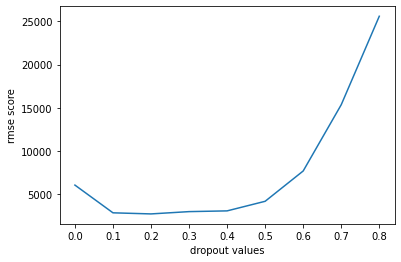

In [64]:
def benchmark_dropout(n):
    dropout_values = [i/10 for i in range(0,n)]
    rmse_score = []
    
    for q in dropout_values :
        model = keras.Sequential()
        
        model.add(keras.Input(shape=(3,1)))
        layer_1 = layers.LSTM(128, activation ="relu", return_sequences=True)
        model.add(layer_1)

        #Dropout permet d'éviter l'overfitting en remplacant certains input par 0 pendant le set de training
        layer_2 = layers.Dropout(q)
        model.add(layer_2)

        layer_3 = layers.GRU(128, activation ="relu")
        model.add(layer_3)

        layer_4 = layers.Dense(32,activation ='relu')
        model.add(layer_4)
        model.summary()

        layer_5 = layers.Dense(1,activation ='relu', input_shape=(1,0))
        model.add(layer_5)

        mse = keras.losses.MeanSquaredError()
        mae = keras.losses.MeanAbsoluteError()
        model.compile(loss= mse,optimizer='rmsprop')

        #Fitting the Recurrent Neural Network
        model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),batch_size = 32, epochs = 50)
        
        rmse_score.append(evaluation(model,X_test)[0][0])
    
    return dropout_values, rmse_score

dropout_values, rmse_score = benchmark_dropout(9)
plt.plot(dropout_values, rmse_score)
plt.ylabel("rmse score")
plt.xlabel("dropout values")

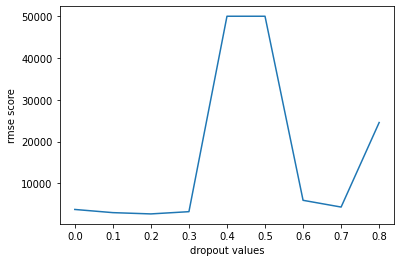

In [70]:
plt.plot(dropout_values, rmse_score)
plt.ylabel("rmse score")
plt.xlabel("dropout values")
plt.savefig('rmse_dropout_values.png', dpi=200)

Train on 2897 samples, validate on 611 samples
Epoch 1/50
2897/2897 [==============================] - 3s 1ms/sample - loss: 3.7172e-04 - val_loss: 0.0011
Epoch 2/50
2897/2897 [==============================] - 1s 231us/sample - loss: 1.2194e-04 - val_loss: 0.0044
Epoch 3/50
2897/2897 [==============================] - 1s 239us/sample - loss: 1.0065e-04 - val_loss: 0.0016
Epoch 4/50
2897/2897 [==============================] - 1s 237us/sample - loss: 9.7428e-05 - val_loss: 6.8187e-04
Epoch 5/50
2897/2897 [==============================] - 1s 241us/sample - loss: 8.8168e-05 - val_loss: 6.7194e-04
Epoch 6/50
2897/2897 [==============================] - 1s 248us/sample - loss: 8.8690e-05 - val_loss: 6.9433e-04
Epoch 7/50
2897/2897 [==============================] - 1s 276us/sample - loss: 8.0107e-05 - val_loss: 4.5250e-04
Epoch 8/50
2897/2897 [==============================] - 1s 251us/sample - loss: 7.8056e-05 - val_loss: 5.2900e-04
Epoch 9/50
2897/2897 [==============================] -

2897/2897 [==============================] - 1s 456us/sample - loss: 4.8173e-05 - val_loss: 0.0011
Epoch 23/50
2897/2897 [==============================] - 1s 447us/sample - loss: 5.0077e-05 - val_loss: 0.0011
Epoch 24/50
2897/2897 [==============================] - 1s 418us/sample - loss: 4.8032e-05 - val_loss: 0.0010
Epoch 25/50
2897/2897 [==============================] - 1s 514us/sample - loss: 4.8922e-05 - val_loss: 5.2304e-04
Epoch 26/50
2897/2897 [==============================] - 1s 482us/sample - loss: 4.3911e-05 - val_loss: 0.0016
Epoch 27/50
2897/2897 [==============================] - 1s 472us/sample - loss: 4.4601e-05 - val_loss: 7.2293e-04
Epoch 28/50
2897/2897 [==============================] - 1s 426us/sample - loss: 4.5199e-05 - val_loss: 4.9008e-04
Epoch 29/50
2897/2897 [==============================] - 1s 418us/sample - loss: 4.7317e-05 - val_loss: 0.0032
Epoch 30/50
2897/2897 [==============================] - 1s 504us/sample - loss: 5.0276e-05 - val_loss: 4.6230e-

2897/2897 [==============================] - 1s 434us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 15/50
2897/2897 [==============================] - 1s 451us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 16/50
2897/2897 [==============================] - 1s 456us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 17/50
2897/2897 [==============================] - 1s 385us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 18/50
2897/2897 [==============================] - 1s 366us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 19/50
2897/2897 [==============================] - 1s 358us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 20/50
2897/2897 [==============================] - 1s 358us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 21/50
2897/2897 [==============================] - 1s 374us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 22/50
2897/2897 [==============================] - 1s 363us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 23/50
2897/2897 [==========================

Epoch 40/50
2897/2897 [==============================] - 1s 407us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 41/50
2897/2897 [==============================] - 1s 398us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 42/50
2897/2897 [==============================] - 1s 398us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 43/50
2897/2897 [==============================] - 1s 395us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 44/50
2897/2897 [==============================] - 1s 445us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 45/50
2897/2897 [==============================] - 1s 430us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 46/50
2897/2897 [==============================] - 1s 440us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 47/50
2897/2897 [==============================] - 1s 400us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 48/50
2897/2897 [==============================] - 1s 407us/sample - loss: 0.0040 - val_loss: 0.1367
Epoch 49/50
2897/2897 [==============

Epoch 12/50
2897/2897 [==============================] - 1s 408us/sample - loss: 1.0309e-04 - val_loss: 0.0019
Epoch 13/50
2897/2897 [==============================] - 1s 400us/sample - loss: 1.0700e-04 - val_loss: 9.5057e-04
Epoch 14/50
2897/2897 [==============================] - 1s 411us/sample - loss: 9.7234e-05 - val_loss: 8.7159e-04
Epoch 15/50
2897/2897 [==============================] - 1s 408us/sample - loss: 9.9124e-05 - val_loss: 7.7901e-04
Epoch 16/50
2897/2897 [==============================] - 1s 400us/sample - loss: 1.0204e-04 - val_loss: 0.0010
Epoch 17/50
2897/2897 [==============================] - 1s 410us/sample - loss: 9.4035e-05 - val_loss: 0.0010
Epoch 18/50
2897/2897 [==============================] - 1s 400us/sample - loss: 9.1920e-05 - val_loss: 0.0028
Epoch 19/50
2897/2897 [==============================] - 1s 438us/sample - loss: 9.3105e-05 - val_loss: 9.1792e-04
Epoch 20/50
2897/2897 [==============================] - 1s 450us/sample - loss: 8.4095e-05 - va

Text(0.5, 0, 'number_dense_layers')

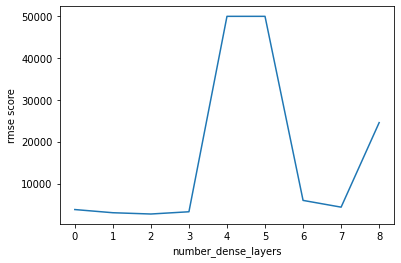

In [67]:
def benchmark_number_dense_layers(n):
    number_dense_layers = [i for i in range(0,n)]
    rmse_score = []
    
    for i in range (0,n) :
        model = keras.Sequential()
        
        model.add(keras.Input(shape=(3,1)))
        layer_1 = layers.LSTM(128, activation ="relu", return_sequences=True)
        model.add(layer_1)

        #Dropout permet d'éviter l'overfitting en remplacant certains input par 0 pendant le set de training
        layer_2 = layers.Dropout(0.2)
        model.add(layer_2)

        layer_3 = layers.GRU(128, activation ="relu")
        model.add(layer_3)
        
        for j in range(0,i):
            model.add(layers.Dense(32,activation ='relu'))

        layer_5 = layers.Dense(1,activation ='relu', input_shape=(1,0))
        model.add(layer_5)

        model.compile(loss= mse,optimizer='rmsprop')

        #Fitting the Recurrent Neural Network
        model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val),batch_size = 32, epochs = 50)
        
        rmse_score.append(evaluation(model,X_test)[0][0])
    
    return number_dense_layers, rmse_score

number_dense_layers, rmse_score = benchmark_number_dense_layers(9)
plt.plot(number_dense_layers, rmse_score)
plt.ylabel("rmse score")
plt.xlabel("number_dense_layers")

Text(0.5, 0, 'number_dense_layers')

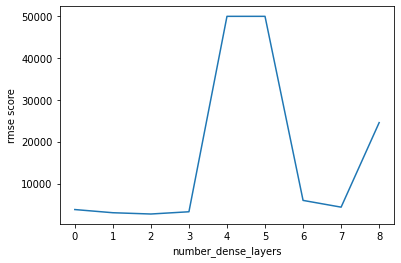

In [68]:
plt.plot(number_dense_layers, rmse_score)
plt.ylabel("rmse score")
plt.xlabel("number_dense_layers")

In [71]:
min(rmse_score)

2720.396743728205

**Résultats pour un test de taille 30**
- 1 LSTM(128), 4 Dense(64,32,32,1) et activations linéaires : rmse 3136.8 et 2470.7
- 1 LSTM(128), 1 Dense(1) et activations linéaires : rmse 2998.2 et 2490.6


- 1 LSTM(128), 1 Dropout(0.1), 1 GRU(128), 2 Dense(32,1); activations relu, optimizer='rmsprop', rmse = 2734.18, mae = 2229
- 1 LSTM(128), 1 GRU(128), 2 Dense(32,1); activations relu, optimizer='rmsprop', rmse = 5271.1, mae = 4587.2
=> sans couche drop out les résultats sont bien moins bon, on essaye donc d'en rajouter une autre couche

- 1 LSTM(128), 1 Dropout(0.1), 1 GRU(128), 1 Dropout(0.1), 2 Dense(32,1); activations relu, optimizer='rmsprop', rmse = 3368.5, mae = 2653.1 ; 2ème essai : rmse = 5628.5 , mae = 5069.9

=> on observe une grande variabilité dans les résultats pour la même architecture du réseau de neurone

=> les résultats sont moins bon, je retire la 2ème couche de dropout mais j'augmente le coefficient de la premiere couche de dropout: 
- 1 LSTM(128), 1 Dropout(0.3), 1 GRU(128), 2 Dense(32,1); activations relu, optimizer='rmsprop', rmse = 2734.18, mae = 2229


**LA TAILLE DU TEST ÉTAIT DE 350 ET PAS DE 30**

Résultats :
batch_size : 32, epochs : 50, optimizer='rmsprop'
<br/> Variation du **type de fonction d'activation** :
- 1 LSTM(128), 4 Dense(64,32,32,1) et activations linéaires : rmse 1329.4
- 1 LSTM(128), 4 Dense(64,32,32,1) et activations relu : rmse 2999.8
- 1 LSTM(128), 4 Dense(64,32,32,1) et activations sigmoid : rmse 15441.1
- 1 LSTM(128), 4 Dense(64,32,32,1) et activations tanh : rmse 12519.1
- 1 LSTM(128), 4 Dense(64,32,32,1) et 3 activations linéaires et tanh sur le dernier : rmse 4983.8
=> Les fonctions d'activations linéaires sur les couches denses permettent d'avoir plus de résultats

**Variation du nombre de unit dans les couches de réseaux de neurones** :
- 1 LSTM(256), 4 Dense(128,128,64,1) et activations linéaires : rmse 1448.3
- 1 LSTM(512), 4 Dense(512,256,128,1) et activations linéaires : rmse 27381.9
<br/> => On obtient des moins bon résultats en augmentant le nombre d'unit, le résultat est particulièrement mauvais dans le deuxième cas, il s'agit d'overfitting
Cette erreur venait du fait que le batch_size était resté à 32, en choissisant un batch_size = 512 : (toujours fonction d'activation linéaire):
- 1 LSTM(512), 4 Dense(512,256,128,1) et activations linéaires : rmse 1803.2
ce résultat n'est cependant toujours pas notre meilleur résultat

**Différente fonctions de perte** :
Je garde le meilleur modèle trouvé jusqu'à présent et je teste différentes fonctions de perte : <br/> 1 LSTM(128), 4 Dense(64,32,32,1) et activations linéaires
- RMSE (Root Mean Squared Error) : rmse_score : 1631.7 ; mae_score : 911.9
- MAE (Mean Absolute Error): rmse_score : 3935.7  ; mae_score : 2030.9
- MAE (Mean Absolute Error) et fonction d'activation relu: rmse_score : 6761.8  ; mae_score : 4018.4
- Huber Loss (moins sensible au données aberrante que le rmse): rmse_score : 3316.2  ; mae_score : 2098.3
- Mean Squared Logarithmic Error : rmse_score : 30499.6 , mae_score : 23245.7
- Cosine_similarity function : rmse_score : 473273.5 , mae_score : 472767.7

<br/> Le meilleur résultat en termes de RMSE et de MAE est obtenu avec la fonction de perte RMSE. Un résultat plutôt bon est obtenu également avec la fonction Huber Loss qui utilise aussi des différences quadratiques mais est moins sensible au données aberrantes. Ici la sensibilité au données aberrantes est particulièrement importante car les données de tests concernent les dernières données où la volatilité est élevée.

**Différents type d'optimizers**:
Jusqu'ici, j'ai utilisé optimizer='rmsprop'. Je teste d'autre optimizer en utilisant les meilleurs paramètres trouvés, c'est à dire :
<br/> LSTM(128), 4 Dense(64,32,32,1), activation linéaire, fonction de perte RSE
- fonction d'optimisation adam : rmse_score : 1416.3 ; mae_score : 817.5
- fonction d'optimisation rmsprop : rmse_score : 2033.0 ; mae_score : 1266.5